In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
y = f(xs)
y

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

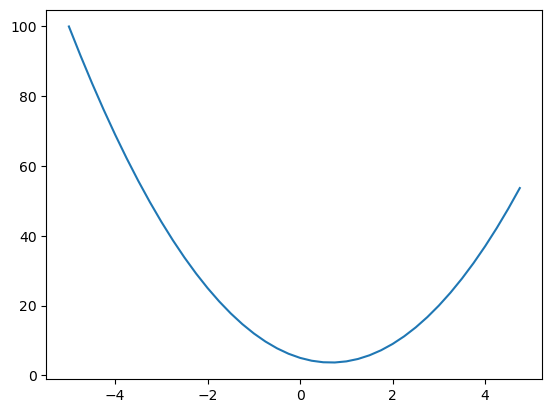

In [6]:
plt.plot(xs,y)

In [7]:
h = 0.000001
x = 2/3
f(x+h)

3.6666666666696663

In [8]:
slope = (f(x+h) - f(x))/h
slope

2.999378523327323e-06

In [9]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [10]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

a+=h
d2 = a*b +c

print('d1 is',d1)
print('d2 is',d2)
print('Slope',(d2-d1)/h)

d1 is 4.0
d2 is 3.999699999999999
Slope -3.000000000010772


In [11]:
class Value:
    def __init__(self,data, _children = (), _op='', label =''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    
        
        return out
    
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self,other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1-t**2)*out.grad
                    
        out._backward = _backward    
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    
a = Value(2.0, label='a')
b = Value(-3.0, label ='b')
c = Value(5.0, label='c')
e = a*b
e.label='e'
d = e+c
d.label ='d'
f = Value(-2.0, label='f')
L = d*f
L.label='L'
L

d.grad = -2.0
f.grad = 4.0

In [12]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

In [13]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }"% (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot    

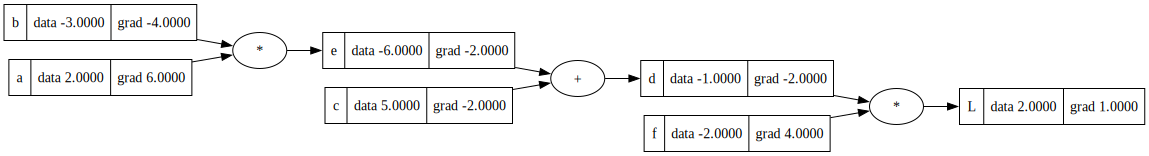

In [14]:
draw_dot(L)

In [15]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label ='b')
    c = Value(5.0, label='c')
    e = a*b
    e.label='e'
    d = e+c
    d.label ='d'
    f = Value(-2.0, label='f')
    L = d*f
    L.label='L'
    L1 = L.data
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label ='b')
    c = Value(5.0, label='c')
    e = a*b
    e.label='e'
    d = e+c
    d.label ='d'
    f = Value(-2.0, label='f')
    L = d*f
    L.label='L'
    L2 = L.data
    
    print((L2-L1)/h)
    
lol()    

6.000000000021544


In [16]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')

x1w1 = x1*w1
x1w1.label = 'x1*w1'

x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'
#o = n.tanh()
e = (2*n).exp()
o = (e-1) / (e+1)
o.label='o'

In [17]:
#n.grad = 1-o.data**2
#x1w1x2w2.grad = 0.6347
#b.grad = 0.6347
#x1w1.grad = 0.6347
#x2w2.grad = 0.6347
#x2.grad = w2.data * x2w2.grad
#w2.grad = x2.data * x2w2.grad
#x1.grad = w1.data * x1w1.grad
#w1.grad = x1.data * x1w1.grad

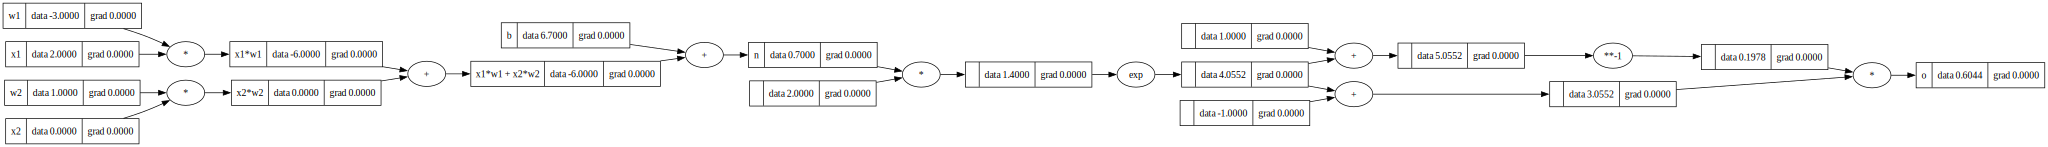

In [18]:
draw_dot(o)

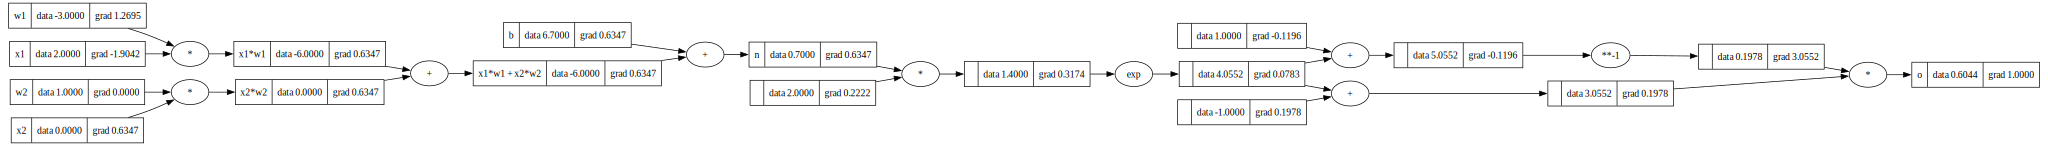

In [19]:
o.backward()
draw_dot(o)

In [20]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [21]:
a = Value(2.0)
b = Value(4.0)
a-b

Value(data=-2.0)